# Regression problem

Types of regression

*   **Linear**: predicting a continuous value, i.e. What temperature will it be today?
*   **Logistic**: predicting category of your observation, i.e. Is this a cat or a dog?
*   **Poisson**: predicting a count value, i.e. How many dog will I see in the park?



In [0]:
# import needed libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pylab import fill_between
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

from patsy import dmatrices
import statsmodels.api as sm


In [0]:
def plotTrainingHist(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Val_Loss', 'Loss'], loc='upper left')
  plt.title(regType + ': Val Loss:' + str(round(np.mean(history.history['val_loss']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def plotTrainingHist2(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Accuracy', 'Loss'], loc='upper left')
  plt.title(regType + ': Accuracy:' + str(round(np.mean(history.history['acc']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def plotTrainingHist3(history, epoch, regType):
  plt.figure(figsize=(15,8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['loss'])
  plt.xlabel('Epoch')
  plt.legend(['Accuracy', 'Loss'], loc='upper left')
  plt.title(regType + ': Accuracy:' + str(round(np.mean(history.history['acc']),2)) + ' ' + 'Loss:'+ str(round(np.mean(history.history['loss']),2)), fontsize=14)
  plt.show()

def confMatrix(X_test, y_test, model, regType):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))
  f, ax = plt.subplots(figsize=(13,8))
  model_y_pred1 = model.predict(X_test, verbose=1)
  model_y_pred= model_y_pred1.round(0)
  model_cm = confusion_matrix(y_test,model_y_pred,[0,1])
  sns.heatmap(model_cm, annot=True, fmt='g', cmap="RdBu", xticklabels = ["0", "1"] , yticklabels = ["0", "1"], ax=ax )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(regType + ' : Confusion Matrix', fontsize=20)

def classReport(X_test, y_test, model):
  y_pred1 = model.predict(X_test)
  y_pred = y_pred1.round(0)
  print(classification_report(y_test, y_pred))

# Styles for Plotting # 
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


### Exercise 1

Bicycle in NYC East [data source](https://www.kaggle.com/new-york-city/nyc-east-river-bicycle-crossings)

In [171]:
import pandas as pd
data1 = pd.read_csv('nyc-east-river-bicycle-counts.csv')
data1.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


In [0]:
data1=data1.head(30)

In [173]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
Unnamed: 0             30 non-null int64
Date                   30 non-null object
Day                    30 non-null object
High Temp (°F)         30 non-null float64
Low Temp (°F)          30 non-null float64
Precipitation          30 non-null object
Brooklyn Bridge        30 non-null float64
Manhattan Bridge       30 non-null int64
Williamsburg Bridge    30 non-null float64
Queensboro Bridge      30 non-null float64
Total                  30 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 2.7+ KB


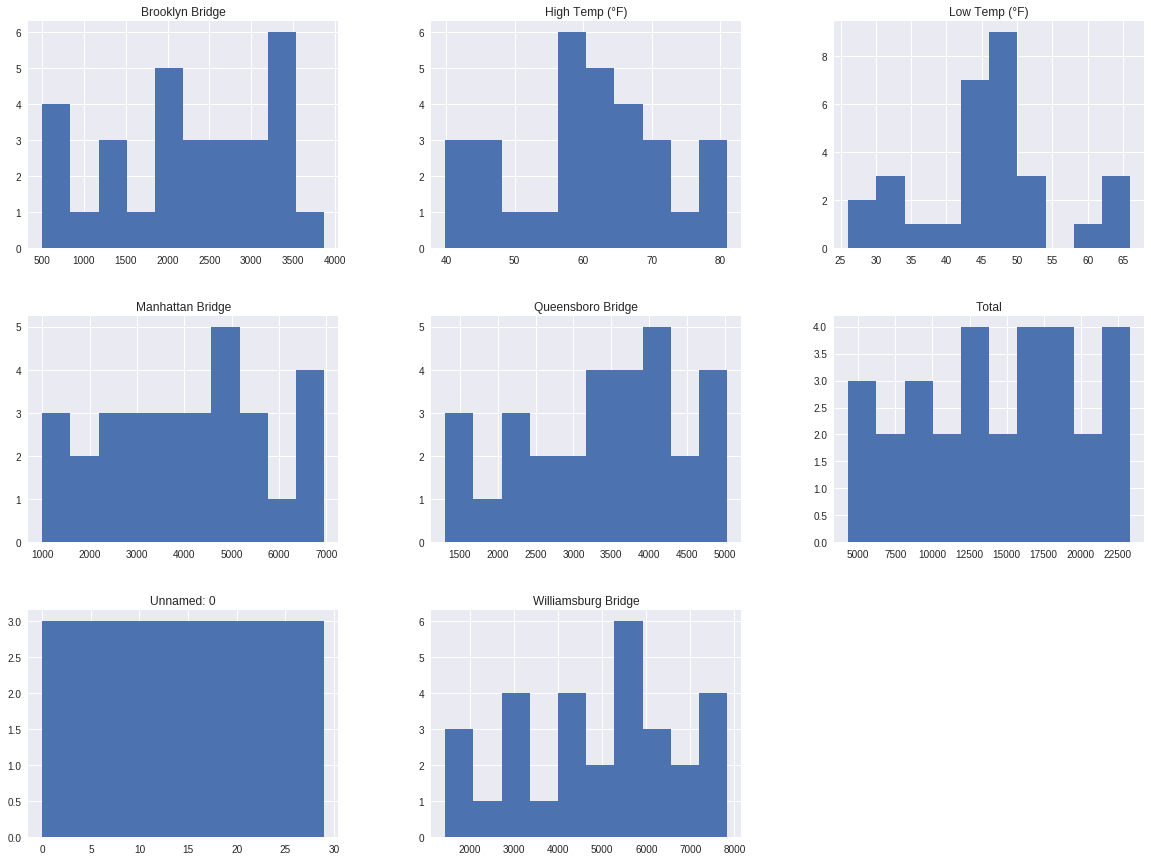

In [174]:
data1.hist(bins=10, figsize=(20,15))
plt.show()

In [175]:
data1.loc[data1['Precipitation'] == '0.47 (S)', 'Precipitation'] = '0.47' #Remove (S) from 0.47 (S)
data1[data1['Precipitation'] == '0.47']
data1['Precipitation']= pd.to_numeric((data1['Precipitation']).astype(str), errors='coerce') #to numeric, all T is converted to nan
data1 = pd.DataFrame(data1.dropna()) 
data1.shape

(29, 11)

In [0]:
data1['Precipitation']=pd.to_numeric(data1.Precipitation)

In [0]:
data1['Date'] = pd.to_datetime(data1['Date'], errors='coerce')
data1['Day']=data1.Date.dt.weekday

In [178]:
data1.head(10)

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01,4,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02,5,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03,6,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,3,2016-04-04,0,44.1,33.1,0.47,521.0,1067,1440.0,1307.0,4335
4,4,2016-04-05,1,42.1,26.1,0.00,1416.0,2617,3081.0,2357.0,9471
5,5,2016-04-06,2,45.0,30.0,0.00,1885.0,3329,3856.0,2849.0,11919
6,6,2016-04-07,3,57.0,53.1,0.09,1276.0,2581,3282.0,2457.0,9596
7,7,2016-04-08,4,46.9,44.1,0.01,1982.0,3455,4113.0,3194.0,12744
8,8,2016-04-09,5,43.0,37.9,0.09,504.0,997,1507.0,1502.0,4510
9,9,2016-04-10,6,48.9,30.9,0.00,1447.0,2387,3132.0,2160.0,9126


In [179]:
data1.describe()

,Unnamed: 0,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14.275862,3.068966,59.975862,45.841379,0.054138,2245.310345,4019.965517,4820.034483,3335.310345,14420.620690
std,8.871691,2.034191,11.046223,9.302362,0.105001,1004.144665,1752.625673,1858.240786,1130.897719,5715.759532
min,0.000000,0.000000,39.900000,26.100000,0.000000,504.000000,997.000000,1440.000000,1306.000000,4335.000000
25%,7.000000,1.000000,55.000000,44.100000,0.000000,1447.000000,2617.000000,3282.000000,2457.000000,9596.000000
50%,14.000000,3.000000,62.100000,46.900000,0.000000,2375.000000,4152.000000,5053.000000,3348.000000,14954.000000
75%,22.000000,5.000000,68.000000,50.000000,0.090000,3147.000000,5309.000000,5995.000000,4192.000000,18315.000000
max,29.000000,6.000000,81.000000,66.000000,0.470000,3871.000000,6951.000000,7834.000000,5032.000000,23318.000000


In [0]:
data1 = data1.drop(['Unnamed: 0','Total','Date'],axis=1)

In [181]:
data1.head()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
0,4,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0
1,5,55.0,48.9,0.15,827.0,1646,2565.0,1884.0
2,6,39.9,34.0,0.09,526.0,1232,1695.0,1306.0
3,0,44.1,33.1,0.47,521.0,1067,1440.0,1307.0
4,1,42.1,26.1,0.00,1416.0,2617,3081.0,2357.0


In [182]:
data1.describe()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,3.068966,59.975862,45.841379,0.054138,2245.310345,4019.965517,4820.034483,3335.310345
std,2.034191,11.046223,9.302362,0.105001,1004.144665,1752.625673,1858.240786,1130.897719
min,0.000000,39.900000,26.100000,0.000000,504.000000,997.000000,1440.000000,1306.000000
25%,1.000000,55.000000,44.100000,0.000000,1447.000000,2617.000000,3282.000000,2457.000000
50%,3.000000,62.100000,46.900000,0.000000,2375.000000,4152.000000,5053.000000,3348.000000
75%,5.000000,68.000000,50.000000,0.090000,3147.000000,5309.000000,5995.000000,4192.000000
max,6.000000,81.000000,66.000000,0.470000,3871.000000,6951.000000,7834.000000,5032.000000


In [183]:
data1.corr()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
Day,1.000000,-0.064930,-0.030920,-0.215411,-0.192043,-0.265805,-0.214418,-0.208788
High Temp (°F),-0.064930,1.000000,0.805983,-0.334064,0.738824,0.727551,0.766709,0.737359
Low Temp (°F),-0.030920,0.805983,1.000000,-0.142855,0.449257,0.461594,0.525649,0.475111
Precipitation,-0.215411,-0.334064,-0.142855,1.000000,-0.594789,-0.584712,-0.571189,-0.592933
Brooklyn Bridge,-0.192043,0.738824,0.449257,-0.594789,1.000000,0.983749,0.980156,0.977857
Manhattan Bridge,-0.265805,0.727551,0.461594,-0.584712,0.983749,1.000000,0.990223,0.985779
Williamsburg Bridge,-0.214418,0.766709,0.525649,-0.571189,0.980156,0.990223,1.000000,0.989541
Queensboro Bridge,-0.208788,0.737359,0.475111,-0.592933,0.977857,0.985779,0.989541,1.000000


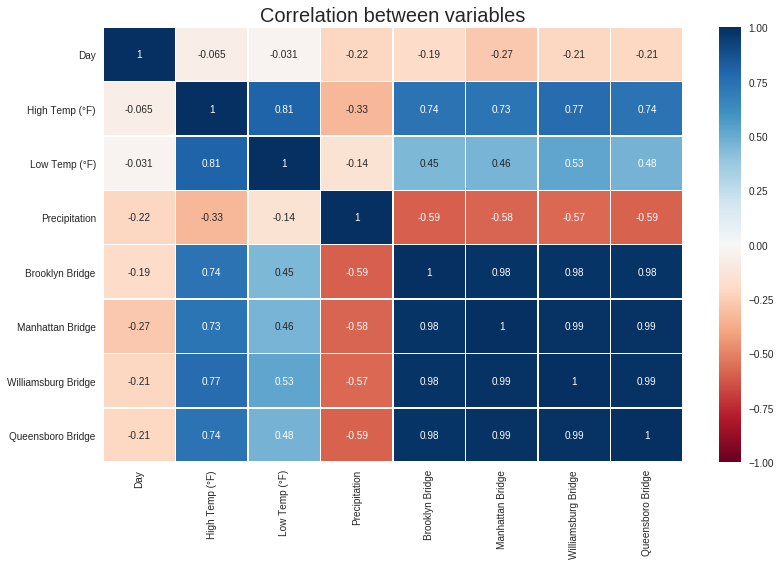

In [184]:
f, ax = plt.subplots(figsize=(13,8))
ax = sns.heatmap(data1.corr(),cmap="RdBu", annot=True, xticklabels=True, yticklabels=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation between variables', fontsize=20);

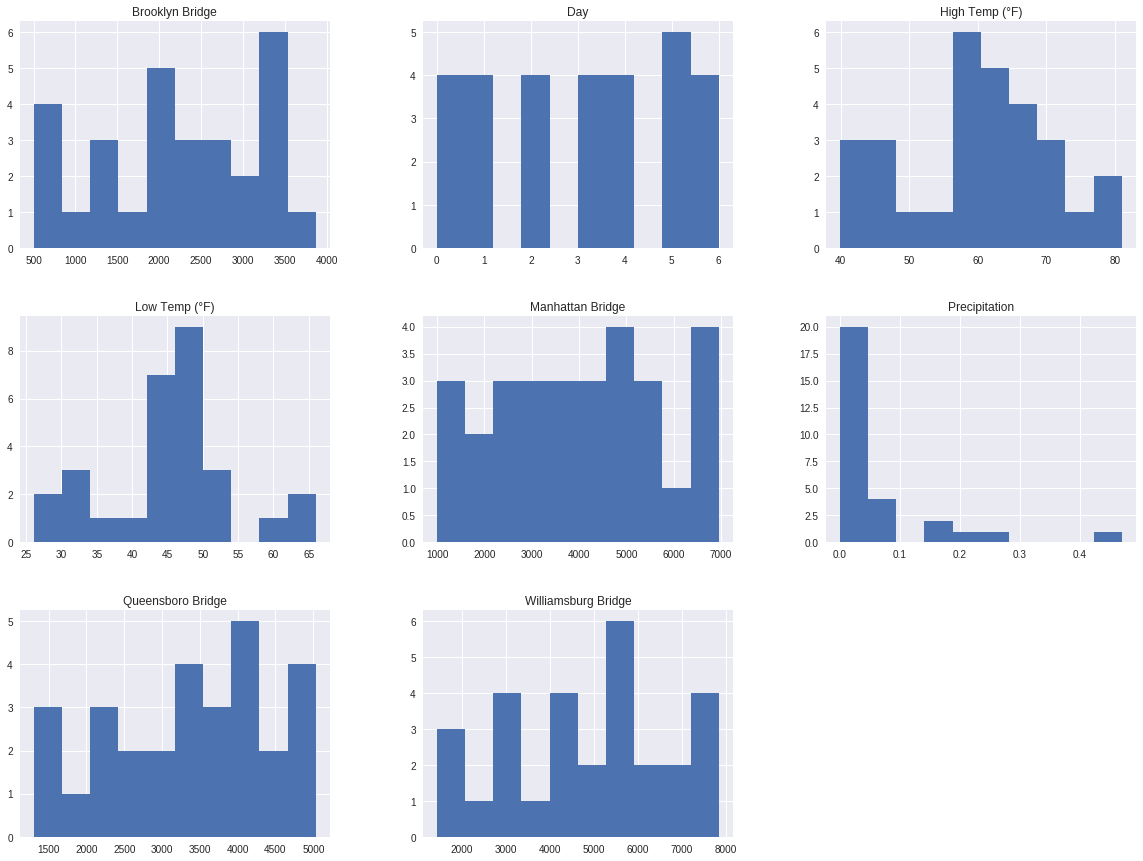

In [185]:
# plotting the histogram of the current data set to view the distribution
data1.hist(bins=10, figsize=(20,15))
plt.show()

In [186]:
data1.describe()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,3.068966,59.975862,45.841379,0.054138,2245.310345,4019.965517,4820.034483,3335.310345
std,2.034191,11.046223,9.302362,0.105001,1004.144665,1752.625673,1858.240786,1130.897719
min,0.000000,39.900000,26.100000,0.000000,504.000000,997.000000,1440.000000,1306.000000
25%,1.000000,55.000000,44.100000,0.000000,1447.000000,2617.000000,3282.000000,2457.000000
50%,3.000000,62.100000,46.900000,0.000000,2375.000000,4152.000000,5053.000000,3348.000000
75%,5.000000,68.000000,50.000000,0.090000,3147.000000,5309.000000,5995.000000,4192.000000
max,6.000000,81.000000,66.000000,0.470000,3871.000000,6951.000000,7834.000000,5032.000000


In [0]:
ss = StandardScaler()
df1 = data1.copy()
#scale_features = ['High Temp (°F)','Low Temp (°F)']
scale_features = ['Brooklyn Bridge','Manhattan Bridge','Williamsburg Bridge','Queensboro Bridge','High Temp (°F)','Low Temp (°F)']
data1[scale_features] = ss.fit_transform(data1[scale_features])

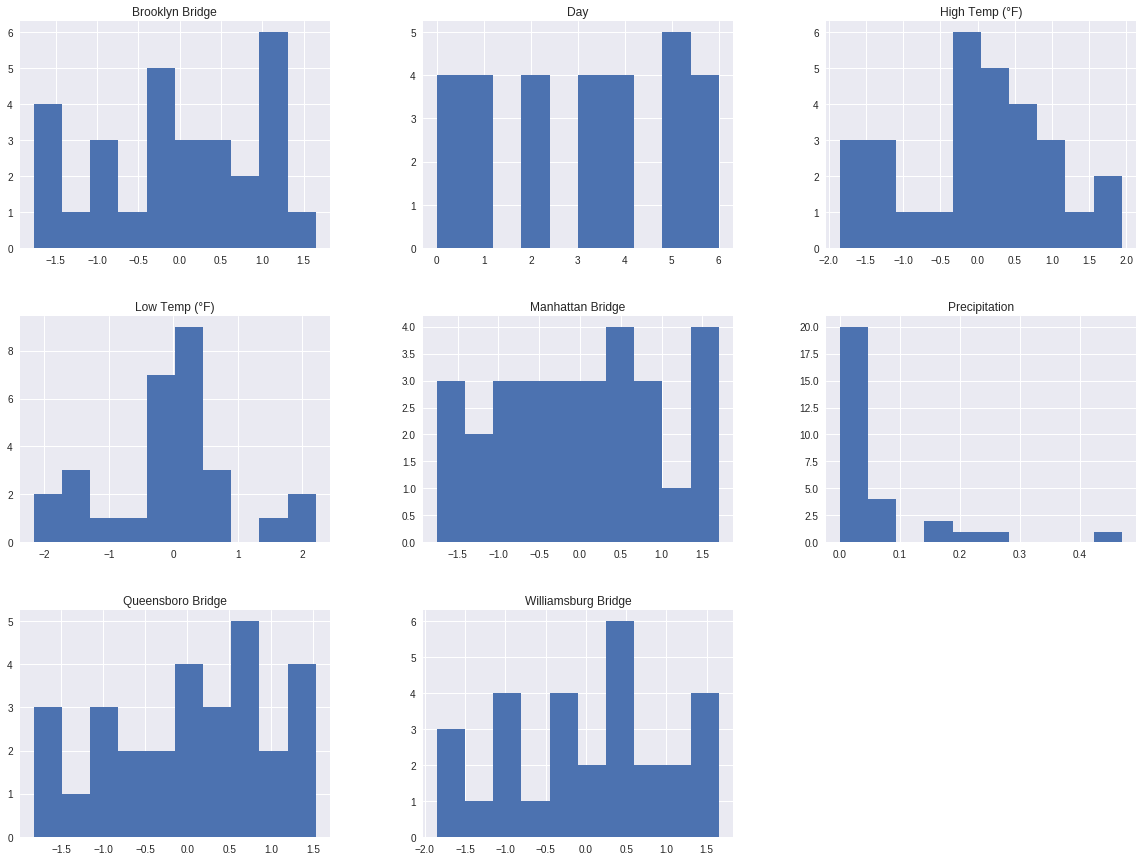

In [188]:
input_features = ['High Temp (°F)','Low Temp (°F)','Day']
output_features = ['Brooklyn Bridge','Manhattan Bridge','Williamsburg Bridge','Queensboro Bridge']
output_features2 = ['Brooklyn Bridge']
data1.hist(bins=10, figsize=(20,15))
plt.show()

In [0]:
# For All Bridges
X = data1.drop(output_features, axis=1).values
y = data1[output_features].values

# For All Bridges Not Normalized
X2 = df1.drop(output_features, axis=1).values
y2 = df1[output_features].values

# For Brooklyn Bridge Only
X1 = df1[input_features].values
y1 = df1[output_features2].values

In [0]:
from sklearn.linear_model import LinearRegression

ls = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=0)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

In [191]:
d1_linear = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
d1_linear

,Actual,Predicted
0,-1.742521,-1.605766
1,-1.618893,-1.717595
2,-1.711484,-1.687605
3,-1.826186,-1.577517
4,1.206764,0.803519
5,1.412214,0.781724
6,1.427206,0.773511
7,1.329780,0.775086
8,1.234128,0.649996
9,1.136976,0.916545


In [192]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.3897823113386888
Mean Squared Error: 0.1984398241794399
Root Mean Squared Error: 0.4454658507444088


<Figure size 432x288 with 0 Axes>

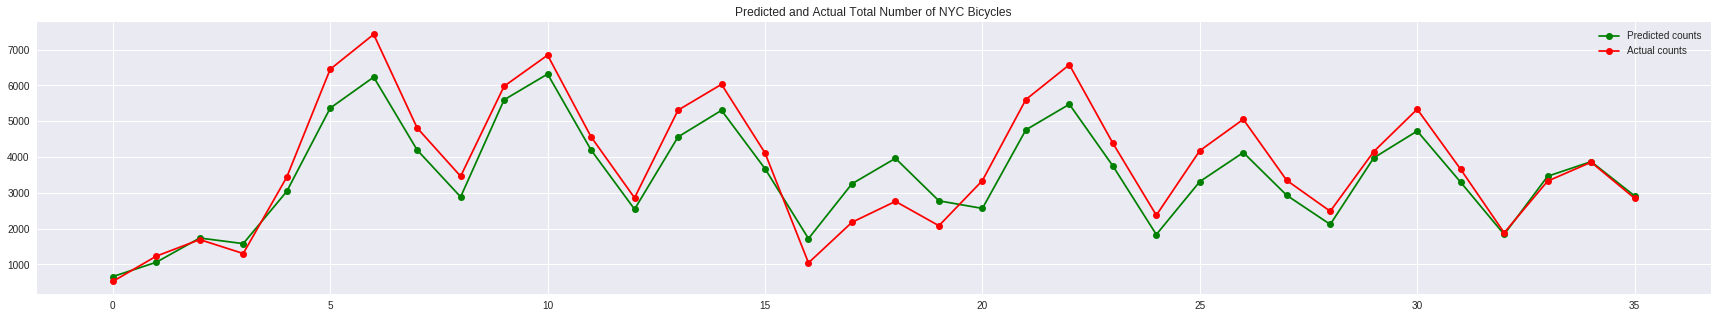

In [193]:
ls = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.30,random_state=0)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

fig = plt.figure()
plt.figure(figsize=(30,5))
plt.title('Predicted and Actual Total Number of NYC Bicycles')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

<Figure size 432x288 with 0 Axes>

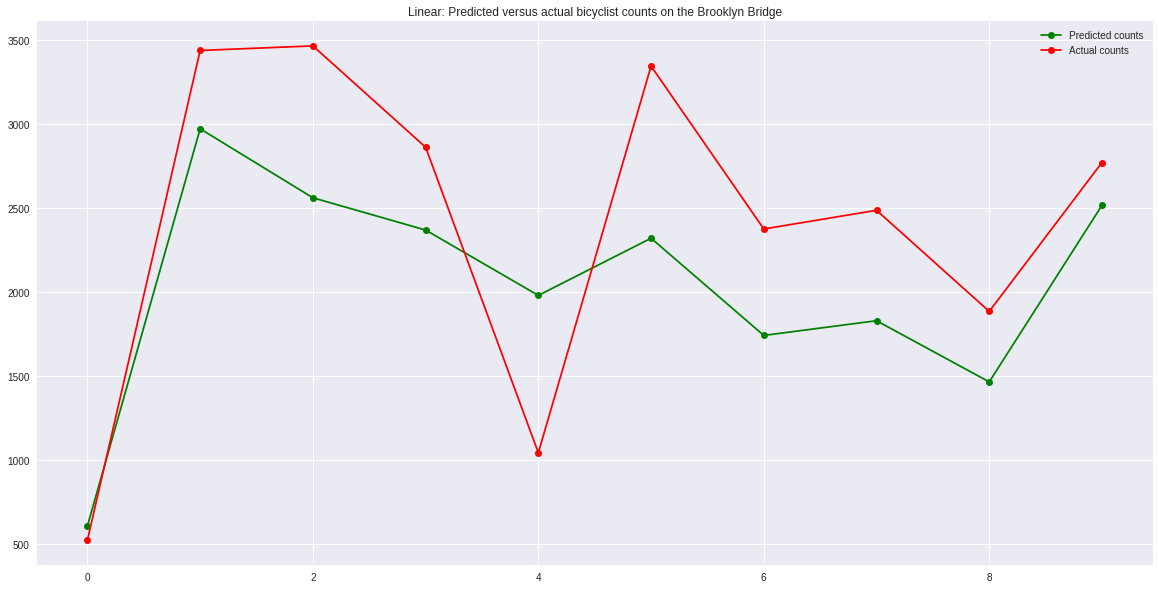

In [194]:
ls = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.33,random_state=0)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Linear: Predicted versus actual bicyclist counts on the Brooklyn Bridge')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [0]:
from keras import backend as K

def rmspe(y_true, y_pred):
        return K.sqrt(K.mean(K.square((y_pred - y_true)/y_true),axis=-1)) 

In [196]:
X_train, X_test , y_train , y_test = train_test_split(X2, y2, test_size=0.30, random_state=0)
lr_model = Sequential()
lr_model.add(Dense(4,input_shape=(X.shape[1],),activation='relu'))
lr_model.compile(Adam(lr=0.5),'mean_squared_error',metrics=[rmspe])
#early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
lr_history = lr_model.fit(X_train,y_train, verbose=1, epochs=300, validation_data=(X_test,y_test), batch_size=1)

Train on 20 samples, validate on 9 samples
Epoch 1/300
20/20 [==============================] - 1s 42ms/step - loss: 13785885.3375 - rmspe: 0.9073 - val_loss: 14548571.9444 - val_rmspe: 0.8474
Epoch 2/300
20/20 [==============================] - 0s 2ms/step - loss: 11852271.2000 - rmspe: 0.8140 - val_loss: 12905395.6806 - val_rmspe: 0.8132
Epoch 3/300
20/20 [==============================] - 0s 2ms/step - loss: 10847842.7250 - rmspe: 0.8198 - val_loss: 12040228.2222 - val_rmspe: 0.8171
Epoch 4/300
20/20 [==============================] - 0s 1ms/step - loss: 10402189.3750 - rmspe: 0.8381 - val_loss: 11585042.8333 - val_rmspe: 0.8216
Epoch 5/300
20/20 [==============================] - 0s 1ms/step - loss: 10166027.2000 - rmspe: 0.8334 - val_loss: 11423950.8472 - val_rmspe: 0.8168
Epoch 6/300
20/20 [==============================] - 0s 2ms/step - loss: 10085254.1000 - rmspe: 0.8378 - val_loss: 11313477.3333 - val_rmspe: 0.8179
Epoch 7/300
20/20 [==============================] - 0s 1ms/st

In [197]:
history_dict = lr_history.history
history_dict.keys()

dict_keys(['val_loss', 'val_rmspe', 'loss', 'rmspe'])

#### Brooklyn Bridge

In [0]:
from patsy import dmatrices
import statsmodels.api as sm

In [199]:
df1.head()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge
0,4,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0
1,5,55.0,48.9,0.15,827.0,1646,2565.0,1884.0
2,6,39.9,34.0,0.09,526.0,1232,1695.0,1306.0
3,0,44.1,33.1,0.47,521.0,1067,1440.0,1307.0
4,1,42.1,26.1,0.00,1416.0,2617,3081.0,2357.0


In [0]:
#Create a pandas DataFrame for the counts data set.
new_data = df1.rename(columns = {"High Temp (°F)": "HIGH_T", 
                                  "Low Temp (°F)":"LOW_T",
                                  "Day":"DAY", 
                                  "Precipitation": "PRECIP",
                                  "Brooklyn Bridge":"BB",
                                  "Manhattan Bridge": "MB",
                                   "Williamsburg Bridge":"WB", 
                                "Queensboro Bridge": "QB",})

# changing columns using .columns() 
df1.columns = ['HIGH_T', 'LOW_T', 'DAY','PRECIP', 'BB', 'MB', 'WB', 'QB'] 
output_features=['BB', 'MB', 'WB', 'QB']

X_1 = df1.drop(output_features, axis=1).values
y_1 = df1['BB'].values

In [201]:
y_1

array([1704.,  827.,  526.,  521., 1416., 1885., 1276., 1982.,  504.,
       1447., 2005., 1045., 2840., 2861., 2770., 2384., 3147., 3871.,
       3501., 3450., 3436., 2055., 2798., 3463., 1997., 3343., 2486.,
       2375., 3199.])

In [202]:
X_train, X_test , y_train , y_test = train_test_split(X_1, y_1, random_state=1)
bb_model = Sequential()
bb_model.add(Dense(1,input_shape=(X.shape[1],),activation='relu'))
bb_model.compile(Adam(lr=0.8),'mean_squared_error',metrics=[rmspe])
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
bb_history = bb_model.fit(X_train,y_train, verbose=2, epochs=1000, validation_data=(X_test,y_test), batch_size=1)

Train on 21 samples, validate on 8 samples
Epoch 1/1000
 - 1s - loss: 2958786.8495 - rmspe: 0.6467 - val_loss: 1909556.0391 - val_rmspe: 0.4945
Epoch 2/1000
 - 0s - loss: 899025.7216 - rmspe: 0.5199 - val_loss: 721535.7261 - val_rmspe: 0.4647
Epoch 3/1000
 - 0s - loss: 641831.4463 - rmspe: 0.5349 - val_loss: 682184.9258 - val_rmspe: 0.4689
Epoch 4/1000
 - 0s - loss: 634219.2280 - rmspe: 0.5263 - val_loss: 701834.9463 - val_rmspe: 0.4658
Epoch 5/1000
 - 0s - loss: 634689.4828 - rmspe: 0.5234 - val_loss: 734863.8416 - val_rmspe: 0.4614
Epoch 6/1000
 - 0s - loss: 631949.8249 - rmspe: 0.5173 - val_loss: 692276.5352 - val_rmspe: 0.4658
Epoch 7/1000
 - 0s - loss: 619316.5691 - rmspe: 0.5211 - val_loss: 682685.8032 - val_rmspe: 0.4669
Epoch 8/1000
 - 0s - loss: 636353.1572 - rmspe: 0.5083 - val_loss: 728047.1587 - val_rmspe: 0.4607
Epoch 9/1000
 - 0s - loss: 621446.4008 - rmspe: 0.5263 - val_loss: 628013.0205 - val_rmspe: 0.4740
Epoch 10/1000
 - 0s - loss: 592931.9657 - rmspe: 0.5149 - val_lo

In [203]:
print('Linear Root Mean Squared Error Percentage:', str(round(np.mean(bb_history.history['rmspe']),3)))

Linear Root Mean Squared Error Percentage: 0.29


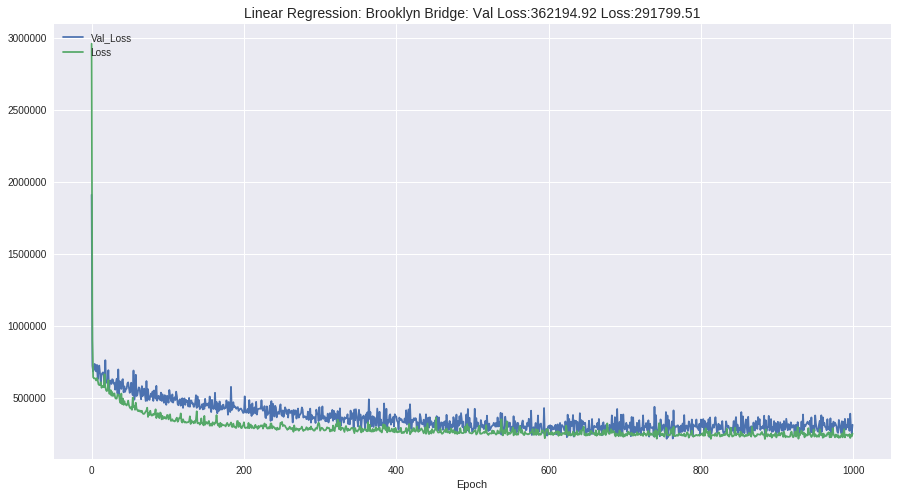

In [204]:
plotTrainingHist(bb_history, 50, 'Linear Regression: Brooklyn Bridge')

In [0]:
y_pred = bb_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

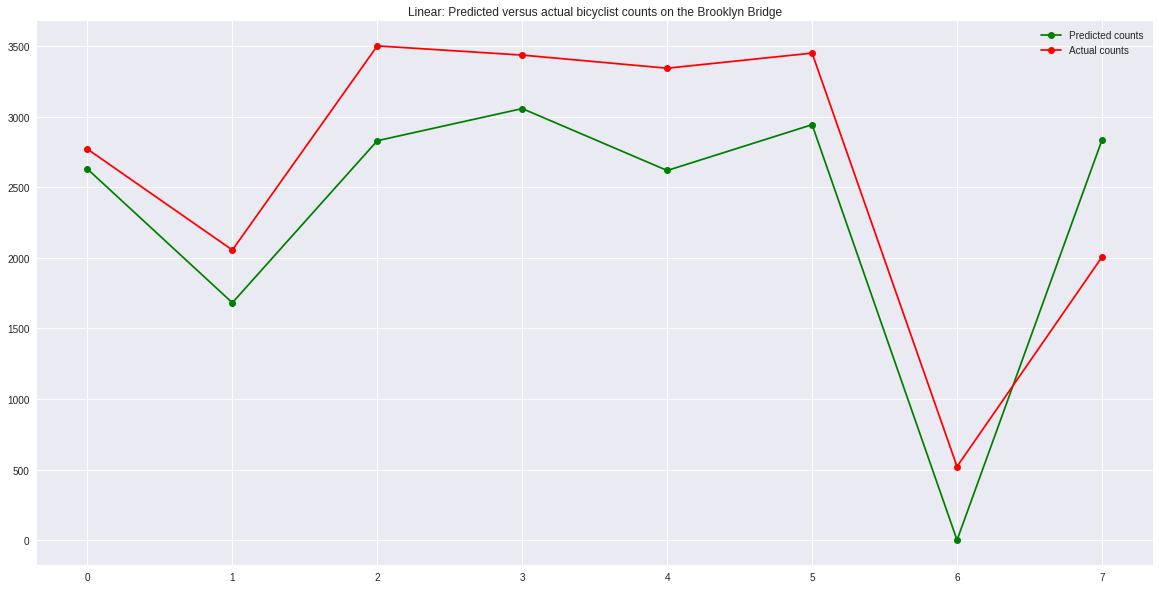

In [206]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Linear: Predicted versus actual bicyclist counts on the Brooklyn Bridge')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [207]:
#Set up the X and y matrices
X_train, X_test , y_train , y_test = train_test_split(X_1, y_1, random_state=1)

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   21
Model:                            GLM   Df Residuals:                       17
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20162.
Date:                Thu, 05 Mar 2020   Deviance:                       40127.
Time:                        20:02:51   Pearson chi2:                 7.65e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1313      0.002     59.154      0.0

In [208]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean    mean_se  mean_ci_lower  mean_ci_upper
0  1615.130646   9.002970    1597.581188    1632.872884
1  7231.344433  90.960057    7055.245649    7411.838640
2  2616.641291  32.894535    2552.956977    2681.914231
3  3057.729882  17.532183    3023.559795    3092.286135
4  1048.009081   5.956677    1036.398997    1059.749225
5  1957.284525  12.123941    1933.665699    1981.191843
6   713.815255  25.673190     665.229315     765.949737
7   831.657081   6.952783     818.140915     845.396543


<Figure size 432x288 with 0 Axes>

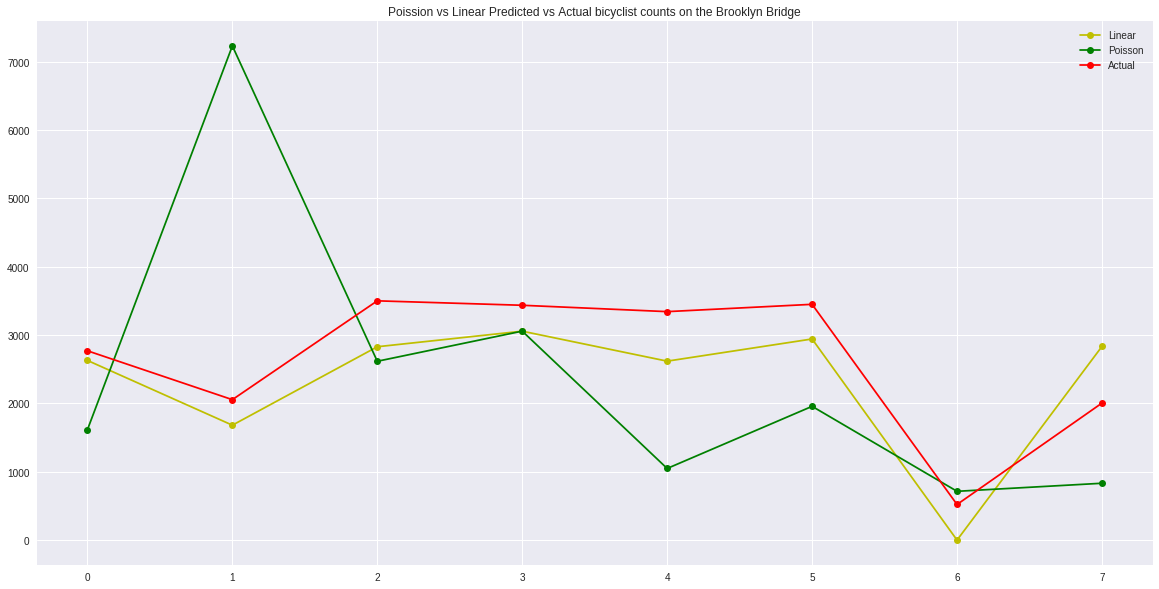

In [209]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = pd.DataFrame(y_test)
 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Poission vs Linear Predicted vs Actual bicyclist counts on the Brooklyn Bridge')
l_predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'yo-', label='Linear')
p_predicted, = plt.plot(pd.DataFrame(X_test).index, predicted_counts, 'go-', label='Poisson')
actual, = plt.plot(pd.DataFrame(X_test).index, actual_counts, 'ro-', label='Actual')

plt.legend(handles=[l_predicted,p_predicted,actual])
 
plt.show()

In [210]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 518.3951568603516
Mean Squared Error: 311900.1143448744
Root Mean Squared Error: 558.4801825892074


#### Manhattan Bridge

In [0]:
X_2 = df1.drop(output_features, axis=1).values
y_2 = df1['MB'].values

In [212]:
X_2

array([[4.00e+00, 7.81e+01, 6.60e+01, 1.00e-02],
       [5.00e+00, 5.50e+01, 4.89e+01, 1.50e-01],
       [6.00e+00, 3.99e+01, 3.40e+01, 9.00e-02],
       [0.00e+00, 4.41e+01, 3.31e+01, 4.70e-01],
       [1.00e+00, 4.21e+01, 2.61e+01, 0.00e+00],
       [2.00e+00, 4.50e+01, 3.00e+01, 0.00e+00],
       [3.00e+00, 5.70e+01, 5.31e+01, 9.00e-02],
       [4.00e+00, 4.69e+01, 4.41e+01, 1.00e-02],
       [5.00e+00, 4.30e+01, 3.79e+01, 9.00e-02],
       [6.00e+00, 4.89e+01, 3.09e+01, 0.00e+00],
       [0.00e+00, 6.21e+01, 4.60e+01, 1.00e-02],
       [1.00e+00, 5.70e+01, 4.50e+01, 2.00e-01],
       [2.00e+00, 5.70e+01, 3.99e+01, 0.00e+00],
       [3.00e+00, 6.21e+01, 4.46e+01, 0.00e+00],
       [4.00e+00, 6.40e+01, 4.41e+01, 0.00e+00],
       [5.00e+00, 6.60e+01, 4.50e+01, 0.00e+00],
       [6.00e+00, 7.39e+01, 4.60e+01, 0.00e+00],
       [0.00e+00, 8.10e+01, 5.20e+01, 0.00e+00],
       [1.00e+00, 7.11e+01, 6.30e+01, 0.00e+00],
       [2.00e+00, 6.80e+01, 5.00e+01, 0.00e+00],
       [3.00e+00, 7.

In [213]:
X_train, X_test , y_train , y_test = train_test_split(X_2, y_2, test_size=0.30, random_state=1)
mb_model = Sequential()
mb_model.add(Dense(1,input_shape=(X.shape[1],),activation='relu'))
mb_model.compile(Adam(lr=0.8),'mean_squared_error',metrics=[rmspe])
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
mb_history = mb_model.fit(X_train,y_train, verbose=2, epochs=1000, validation_data=(X_test,y_test), batch_size=1)

Train on 20 samples, validate on 9 samples
Epoch 1/1000
 - 1s - loss: 10584150.5711 - rmspe: 0.7577 - val_loss: 14339387.1658 - val_rmspe: 0.6048
Epoch 2/1000
 - 0s - loss: 4750566.6823 - rmspe: 0.4262 - val_loss: 7010014.3286 - val_rmspe: 0.4656
Epoch 3/1000
 - 0s - loss: 2269977.1643 - rmspe: 0.4157 - val_loss: 4335236.6580 - val_rmspe: 0.4429
Epoch 4/1000
 - 0s - loss: 1704522.8661 - rmspe: 0.4135 - val_loss: 3612046.3312 - val_rmspe: 0.4342
Epoch 5/1000
 - 0s - loss: 1614784.2721 - rmspe: 0.4186 - val_loss: 3270585.5322 - val_rmspe: 0.4293
Epoch 6/1000
 - 0s - loss: 1608454.0016 - rmspe: 0.4257 - val_loss: 3171584.5611 - val_rmspe: 0.4274
Epoch 7/1000
 - 0s - loss: 1615484.3457 - rmspe: 0.4272 - val_loss: 3014020.1398 - val_rmspe: 0.4255
Epoch 8/1000
 - 0s - loss: 1625347.3936 - rmspe: 0.4323 - val_loss: 3040680.4219 - val_rmspe: 0.4249
Epoch 9/1000
 - 0s - loss: 1581543.3556 - rmspe: 0.4256 - val_loss: 3166300.9623 - val_rmspe: 0.4259
Epoch 10/1000
 - 0s - loss: 1616725.3973 - rms

In [214]:
print('Linear Root Mean Squared Error Percentage:', str(round(np.mean(mb_history.history['rmspe']),3)))

Linear Root Mean Squared Error Percentage: 0.252


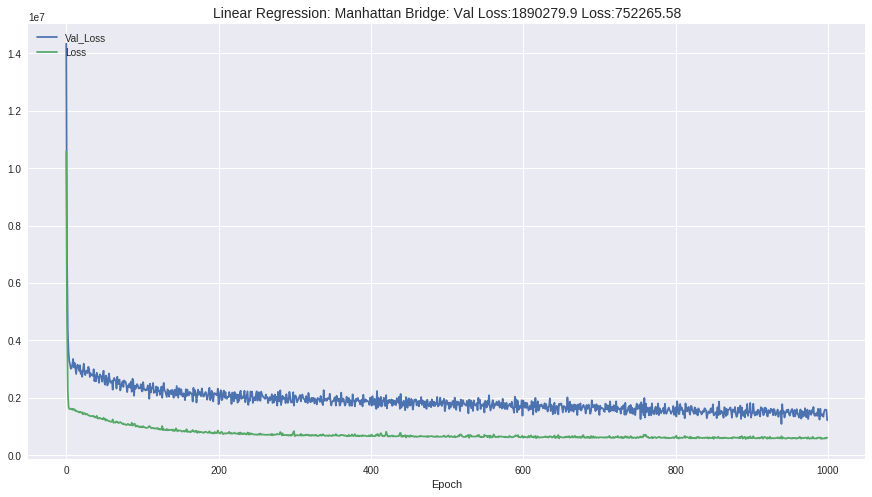

In [215]:
plotTrainingHist(mb_history, 50, 'Linear Regression: Manhattan Bridge')

In [0]:
y_pred = mb_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

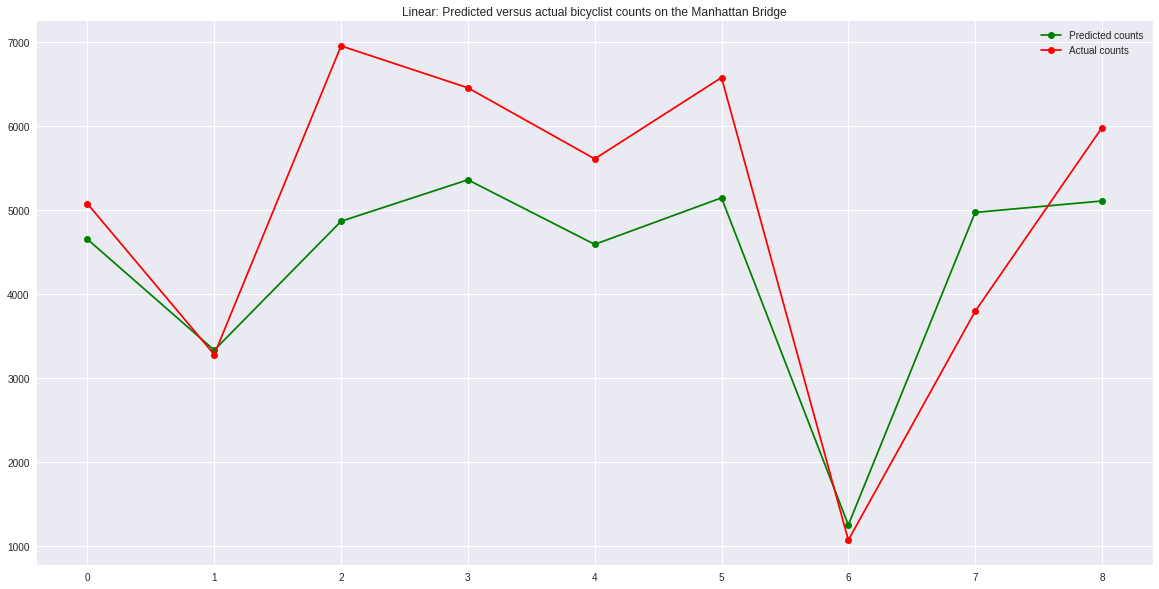

In [217]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Linear: Predicted versus actual bicyclist counts on the Manhattan Bridge')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [218]:
#Set up the X and y matrices
X_train, X_test , y_train , y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=0)
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33819.
Date:                Thu, 05 Mar 2020   Deviance:                       67439.
Time:                        20:03:25   Pearson chi2:                 1.35e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0827      0.002     50.901      0.0

In [219]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean    mean_se  mean_ci_lower  mean_ci_upper
0   214.774836   1.616718     211.629387     217.967035
1  5019.979566  20.811388    4979.355264    5060.935304
2  2375.372098  16.888998    2342.499847    2408.705644
3  1758.899318   6.250797    1746.690550    1771.193421
4  1395.572337  13.602152    1369.165637    1422.488335
5  1613.158003   6.262247    1600.930799    1625.478593
6  1194.651033   5.001028    1184.889299    1204.493189
7  1067.776553   4.924408    1058.168380    1077.471967
8   222.344045   0.664730     221.045008     223.650717


<Figure size 432x288 with 0 Axes>

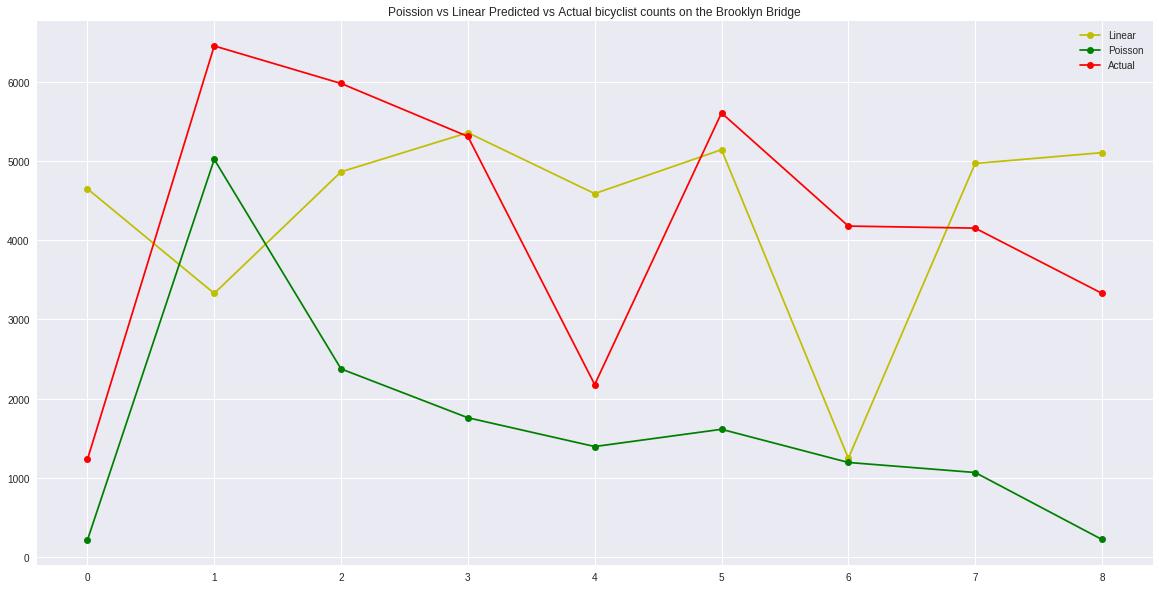

In [220]:
predicted_counts = predictions_summary_frame['mean']
actual_counts = pd.DataFrame(y_test)
 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Poission vs Linear Predicted vs Actual bicyclist counts on the Brooklyn Bridge')
l_predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'yo-', label='Linear')
p_predicted, = plt.plot(pd.DataFrame(X_test).index, predicted_counts, 'go-', label='Poisson')
actual, = plt.plot(pd.DataFrame(X_test).index, actual_counts, 'ro-', label='Actual')

plt.legend(handles=[l_predicted,p_predicted,actual])
 
plt.show()

In [221]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1788.9131401909722
Mean Squared Error: 4567877.0936927395
Root Mean Squared Error: 2137.2592481242746


#### Williamsburg Bridge

In [0]:
X_3 = df1.drop(output_features, axis=1).values
y_3 = df1['WB'].values

In [223]:
y_3

array([4115., 2565., 1695., 1440., 3081., 3856., 3282., 4113., 1507.,
       3132., 4334., 2762., 5995., 6030., 5816., 5624., 5867., 7432.,
       7834., 7639., 7426., 4856., 5335., 6845., 4559., 6577., 5336.,
       5053., 5675.])

In [243]:
X_train, X_test , y_train , y_test = train_test_split(X_3, y_3, test_size=0.30, random_state=1)
wb_model = Sequential()
wb_model.add(Dense(1,input_shape=(X.shape[1],),activation='relu'))
wb_model.compile(Adam(lr=0.8),'mean_squared_error',metrics=[rmspe])
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
wb_history = wb_model.fit(X_train,y_train, verbose=2, epochs=1000, validation_data=(X_test,y_test), batch_size=1,callbacks=[early_stop])

Train on 20 samples, validate on 9 samples
Epoch 1/1000
 - 1s - loss: 15265039.8000 - rmspe: 0.8104 - val_loss: 20525826.5035 - val_rmspe: 0.6596
Epoch 2/1000
 - 0s - loss: 6972142.6459 - rmspe: 0.4802 - val_loss: 10478674.4861 - val_rmspe: 0.4775
Epoch 3/1000
 - 0s - loss: 3187578.8084 - rmspe: 0.3387 - val_loss: 6093226.0035 - val_rmspe: 0.3914
Epoch 4/1000
 - 0s - loss: 1910840.0309 - rmspe: 0.3256 - val_loss: 4180919.9086 - val_rmspe: 0.3562
Epoch 5/1000
 - 0s - loss: 1656992.9344 - rmspe: 0.3306 - val_loss: 3439137.5494 - val_rmspe: 0.3494
Epoch 6/1000
 - 0s - loss: 1647721.6760 - rmspe: 0.3303 - val_loss: 3362132.5048 - val_rmspe: 0.3493
Epoch 7/1000
 - 0s - loss: 1637619.6964 - rmspe: 0.3291 - val_loss: 3456519.8391 - val_rmspe: 0.3490
Epoch 8/1000
 - 0s - loss: 1622948.4552 - rmspe: 0.3266 - val_loss: 3046113.8854 - val_rmspe: 0.3495
Epoch 9/1000
 - 0s - loss: 1642740.2826 - rmspe: 0.3321 - val_loss: 3314124.7313 - val_rmspe: 0.3490
Epoch 10/1000
 - 0s - loss: 1574543.6623 - rm

In [244]:
print('Linear Root Mean Squared Error Percentage:', str(round(np.mean(wb_history.history['rmspe']),3)))

Linear Root Mean Squared Error Percentage: 0.346


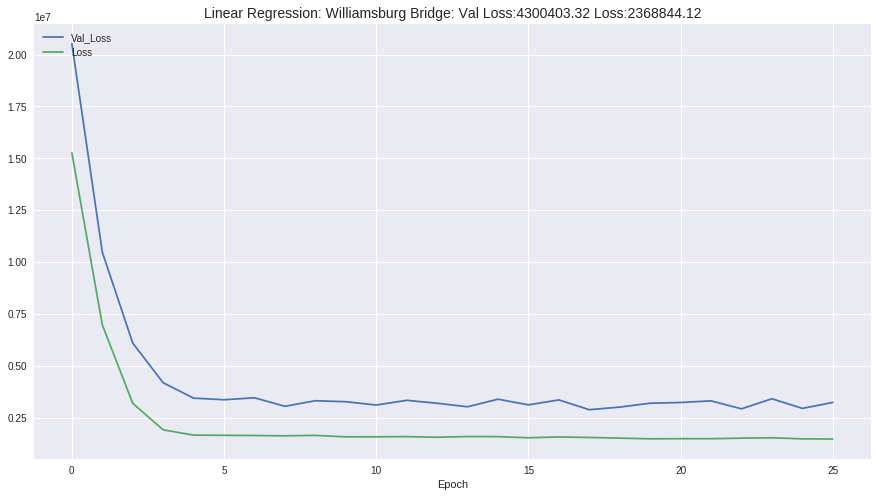

In [245]:
plotTrainingHist(wb_history, 50, 'Linear Regression: Williamsburg Bridge')

In [0]:
y_pred = wb_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

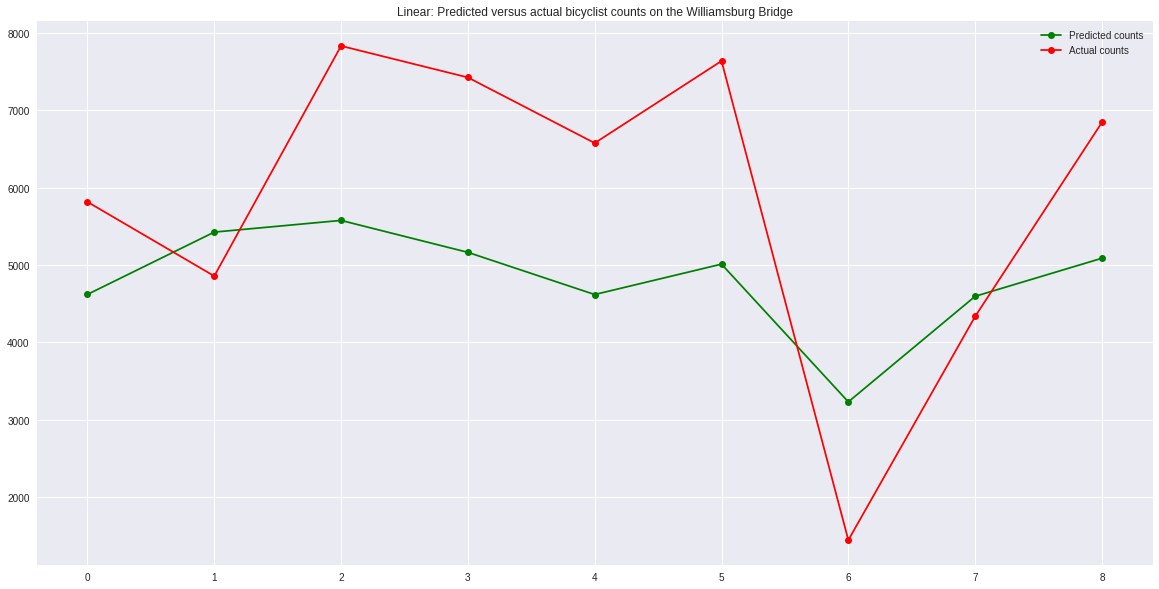

In [247]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Linear: Predicted versus actual bicyclist counts on the Williamsburg Bridge')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [229]:
#Set up the X and y matrices
X_train, X_test , y_train , y_test = train_test_split(X_3, y_3, test_size=0.30, random_state=0)

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40848.
Date:                Thu, 05 Mar 2020   Deviance:                       81492.
Time:                        20:03:29   Pearson chi2:                 1.69e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1014      0.002     67.570      0.0

In [230]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean    mean_se  mean_ci_lower  mean_ci_upper
0   273.263920   1.854565     269.653107     276.923084
1  5795.108380  22.327200    5751.512681    5839.034529
2  2592.404623  17.186957    2558.936718    2626.310248
3  2009.496642   6.573894    1996.653265    2022.422633
4  1809.131272  14.955964    1780.054324    1838.683189
5  1811.908255   6.549832    1799.116190    1824.791275
6  1447.113280   5.400870    1436.566391    1457.737602
7  1219.296488   5.089154    1209.362618    1229.311957
8   243.663758   0.675817     242.342775     244.991941


<Figure size 432x288 with 0 Axes>

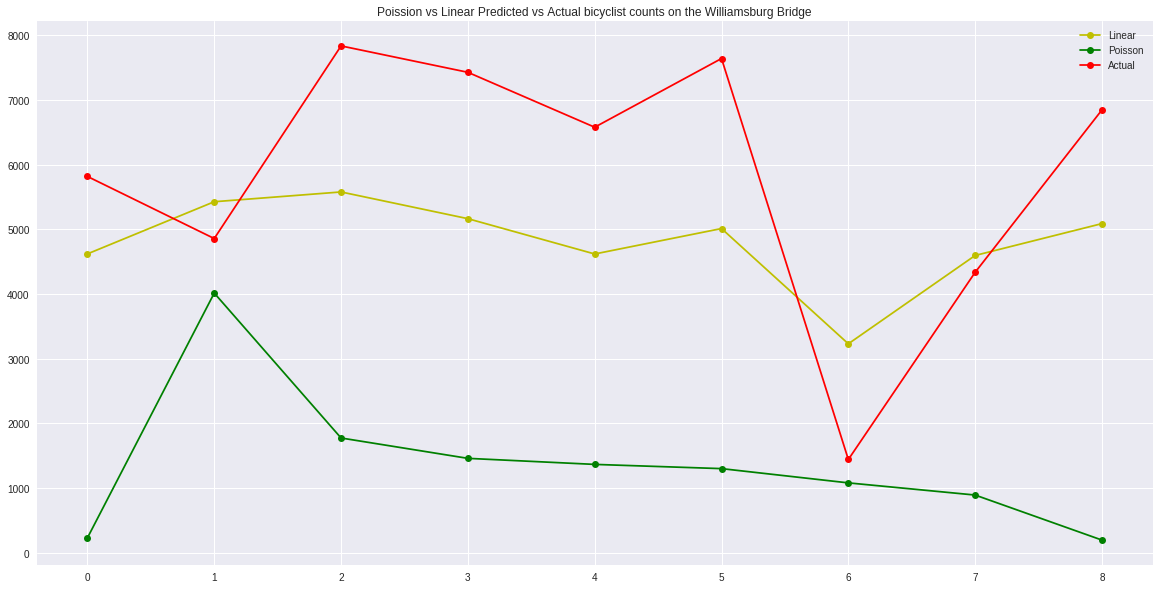

In [248]:
predicted_counts = predictions_summary_frame['mean']
actual_counts = pd.DataFrame(y_test)
 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Poission vs Linear Predicted vs Actual bicyclist counts on the Williamsburg Bridge')
l_predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'yo-', label='Linear')
p_predicted, = plt.plot(pd.DataFrame(X_test).index, predicted_counts, 'go-', label='Poisson')
actual, = plt.plot(pd.DataFrame(X_test).index, actual_counts, 'ro-', label='Actual')

plt.legend(handles=[l_predicted,p_predicted,actual])
 
plt.show()

In [232]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5064.444444444444
Mean Squared Error: 28999271.111111112
Root Mean Squared Error: 5385.097131074899


#### Queensboro Bridge

In [0]:
X_4 = df1.drop(output_features, axis=1).values
y_4 = df1['QB'].values

In [234]:
X_train, X_test , y_train , y_test = train_test_split(X_4, y_4, test_size=0.30, random_state=1)
qb_model = Sequential()
qb_model.add(Dense(1,input_shape=(X.shape[1],),activation='relu'))
qb_model.compile(Adam(lr=0.8),'mean_squared_error',metrics=[rmspe])
early_stop = EarlyStopping(monitor='val_loss',patience=8,verbose=1)
qb_history = qb_model.fit(X_train,y_train, verbose=2, epochs=1000, validation_data=(X_test,y_test), batch_size=1)

Train on 20 samples, validate on 9 samples
Epoch 1/1000
 - 1s - loss: 6689880.7178 - rmspe: 0.7006 - val_loss: 6071013.3529 - val_rmspe: 0.5337
Epoch 2/1000
 - 0s - loss: 2028126.6836 - rmspe: 0.3513 - val_loss: 2150536.1487 - val_rmspe: 0.3199
Epoch 3/1000
 - 0s - loss: 807348.1099 - rmspe: 0.2627 - val_loss: 1155899.9197 - val_rmspe: 0.2746
Epoch 4/1000
 - 0s - loss: 702029.5334 - rmspe: 0.2878 - val_loss: 967097.3207 - val_rmspe: 0.2620
Epoch 5/1000
 - 0s - loss: 744331.5583 - rmspe: 0.2923 - val_loss: 907540.0605 - val_rmspe: 0.2607
Epoch 6/1000
 - 0s - loss: 713349.1096 - rmspe: 0.2837 - val_loss: 1063826.2382 - val_rmspe: 0.2679
Epoch 7/1000
 - 0s - loss: 733939.4711 - rmspe: 0.2879 - val_loss: 1063866.8257 - val_rmspe: 0.2675
Epoch 8/1000
 - 0s - loss: 721914.6596 - rmspe: 0.2891 - val_loss: 866240.7511 - val_rmspe: 0.2590
Epoch 9/1000
 - 0s - loss: 697310.2502 - rmspe: 0.2840 - val_loss: 1039276.8682 - val_rmspe: 0.2651
Epoch 10/1000
 - 0s - loss: 704216.2152 - rmspe: 0.2815 - 

In [235]:
print('Linear Root Mean Squared Error Percentage:', str(round(np.mean(qb_history.history['rmspe']),3)))

Linear Root Mean Squared Error Percentage: 0.176


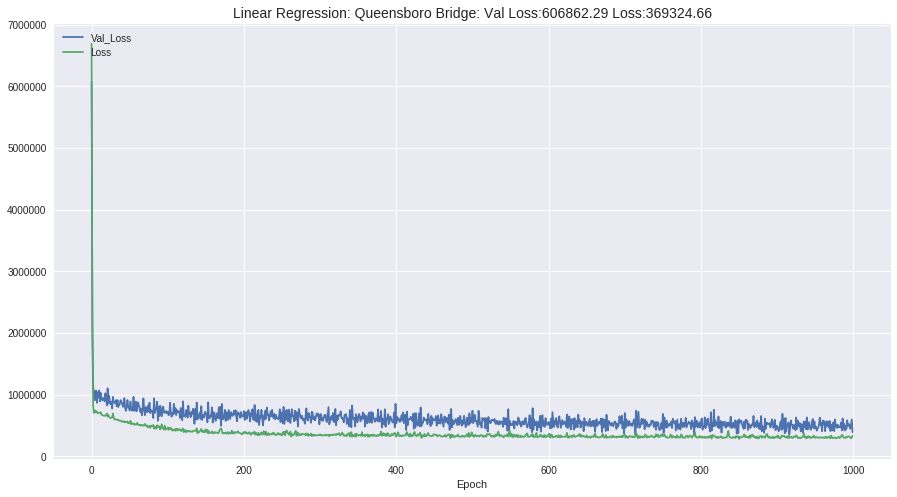

In [236]:
plotTrainingHist(qb_history, 50, 'Linear Regression: Queensboro Bridge')

In [0]:
y_pred = qb_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

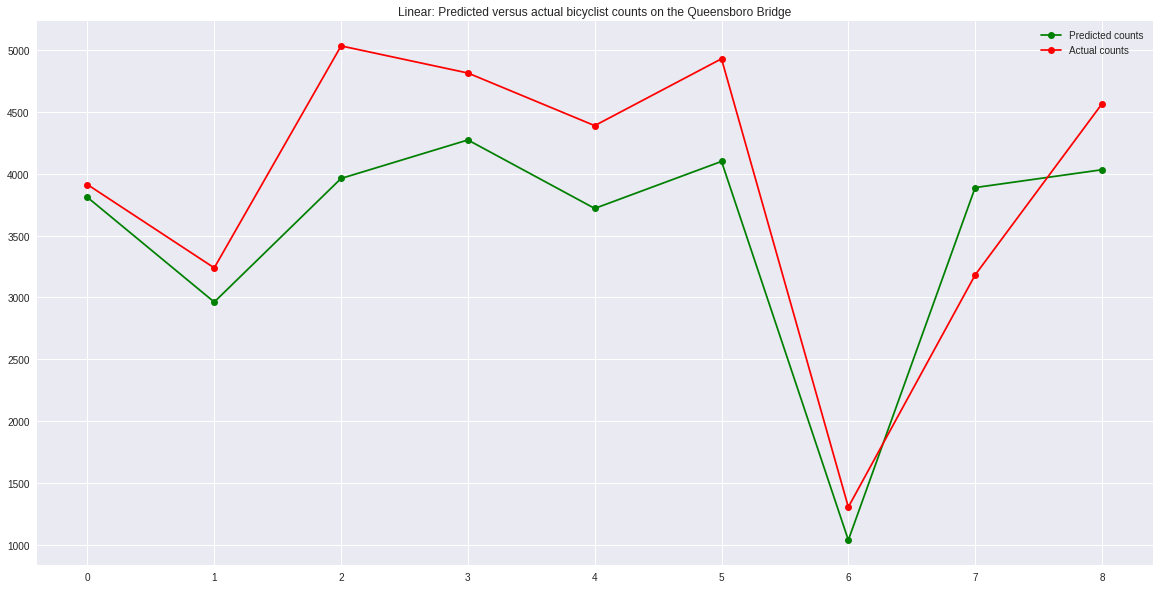

In [238]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Linear: Predicted versus actual bicyclist counts on the Queensboro Bridge')
predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'go-', label='Predicted counts')
actual, = plt.plot(pd.DataFrame(y_test.flatten()), 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
 
plt.show()

In [239]:
#Set up the X and y matrices
X_train, X_test , y_train , y_test = train_test_split(X_4, y_4, test_size=0.30, random_state=0)

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28563.
Date:                Thu, 05 Mar 2020   Deviance:                       56929.
Time:                        20:04:03   Pearson chi2:                 1.19e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1074      0.002     59.461      0.0

In [240]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
 
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean    mean_se  mean_ci_lower  mean_ci_upper
0   228.118926   1.853309     224.515274     231.780419
1  4012.828661  18.739343    3976.267795    4049.725697
2  1772.380107  14.350753    1744.475154    1800.731433
3  1457.616620   5.749332    1446.391581    1468.928772
4  1364.230065  12.920577    1339.139793    1389.790432
5  1298.885574   5.744993    1287.674260    1310.194500
6  1078.429938   4.836256    1068.992587    1087.950604
7   890.364799   4.493945     881.600253     899.216479
8   194.018475   0.649357     192.749924     195.295374


<Figure size 432x288 with 0 Axes>

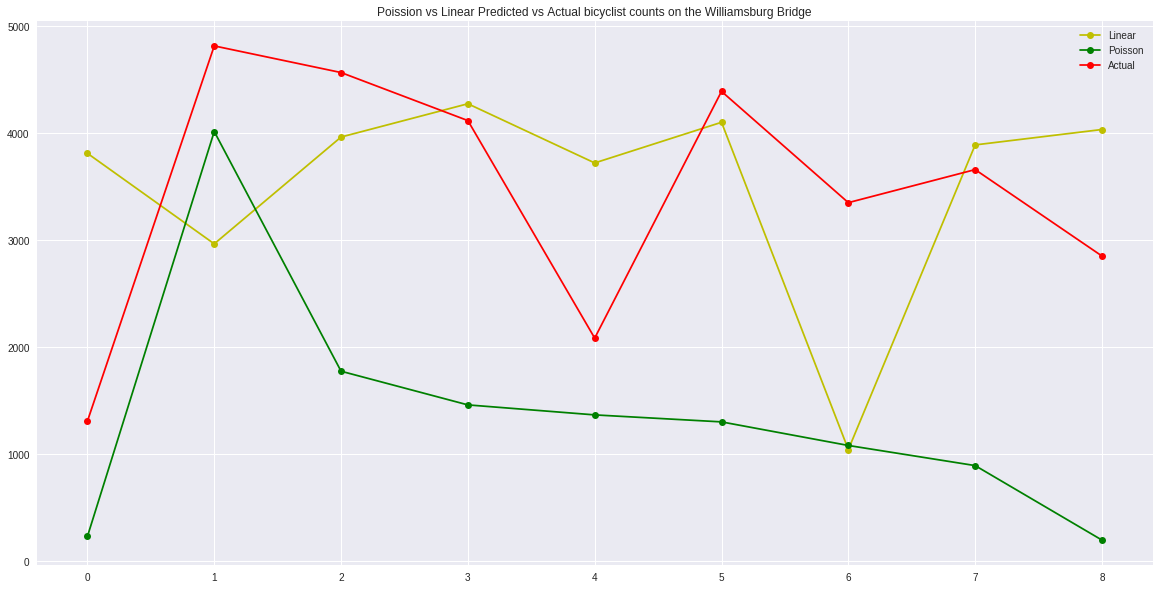

In [241]:
predicted_counts = predictions_summary_frame['mean']
actual_counts = pd.DataFrame(y_test)
 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title('Poission vs Linear Predicted vs Actual bicyclist counts on the Williamsburg Bridge')
l_predicted, = plt.plot(pd.DataFrame(y_pred.flatten()), 'yo-', label='Linear')
p_predicted, = plt.plot(pd.DataFrame(X_test).index, predicted_counts, 'go-', label='Poisson')
actual, = plt.plot(pd.DataFrame(X_test).index, actual_counts, 'ro-', label='Actual')

plt.legend(handles=[l_predicted,p_predicted,actual])
 
plt.show()

In [242]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1195.5784233940972
Mean Squared Error: 2179694.948706647
Root Mean Squared Error: 1476.378999006233
